<a href="https://colab.research.google.com/github/nicholassung97/DecomposeFit/blob/main/change_fit_function_draft2(cos_similarity).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Code-1.0: ml-PINN for 1D Convection-Diffusion Equation

Tasks:
    
    1. PDE-NN for 1D convection-diffusion equation:
        1.0. Data
        1.1. Geometry & BC
        1.2. Sampling plan
        1.3. PDE-NN 
    2. Optimize PDE-NN: [SGD]
    3. Visualize training dynamic

Purpose:

    1. Study PDE-NN flexibility 

#1. Import Libraries

In [ ]:
!pip install matplotlib

%matplotlib inline
import matplotlib.pylab as plt 
from matplotlib import cm

import os
import math
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

from IPython.display import clear_output
from time import time, gmtime, strftime, localtime

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy import pi

import seaborn as sns

## run on CPU...
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable eager excution
# tf.compat.v1.disable_eager_execution()

 **PDE-NN for 1D convection-diffusion equation**

      
**Prior**

    1. Convection-Diffusion Equation: toy problem for a one-dimensional steady-state case 
        - v*u_x = k*u_xx
    2. BC 
        - u = 0, x = 0
        - u = 1, x = L
    3. General solution
        - u(x) = C1 + D1 exp(ux/k)
    4. Given BCs specified in 2, the solution become
        - u(x) = [1 - exp(Pe x/L)] / [1 - exp(Pe)]
        - Pe = uL/k
        

# 2. Data

In [ ]:
# function to generate analytical solution
def eval_u(x, Pe, L):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    u = tf.convert_to_tensor((1. - tf.math.exp(Pe*x/L)) / (1. - tf.math.exp(Pe)))
    return u#.eval(session=tf.compat.v1.Session()) 

def eval_Pe(u, k, L):
    return u*L/k

#### 2.1. Geometry & BC

In [ ]:
# choose v (PDE parameter)
v = 10.

# fixed PDE & BC parameters k & L
k = 1.
L = 1.
Pe = eval_Pe(v, k, L)

# domain boundary
x_l, x_u = 0, L

#### 2.2. Sampling plan

# training sample = 5000


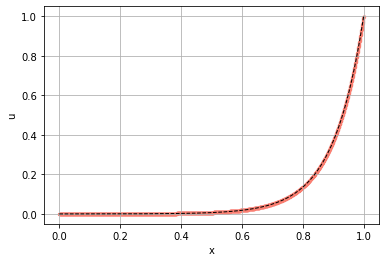

In [ ]:
# training data
n = 5000
x = np.linspace(x_l, x_u, n)
X_train = np.hstack([x.reshape(-1, 1), np.ones((len(x), 1))])
y_train = np.reshape(eval_u(x, Pe, L),(-1, 1))

print ('# training sample = %d' %len(y_train))

# viz training data
plt.plot(x, eval_u(x, Pe, L), "k--", linewidth=1); plt.scatter(X_train[:, 0], y_train, c='salmon', alpha=.5, s=5);
plt.xlabel('x'); plt.ylabel('u'); plt.grid();

In [ ]:
# BC data
bc = np.where((X_train[:,0] == x_l) | (X_train[:,0] == x_u))[0]
X_bc, y_bc = X_train[bc], y_train[bc]

In [ ]:
# evaluation data
X_eval, y_eval = X_train, y_train

# PDE data
X_pde, y_pde = X_train, y_train
X_ic, y_ic = X_bc, y_bc


2.3 Preparation of training data

In [ ]:
# create multiple batches

# taking a random sample of 498 PDE points and 2 BC points
batch_pde, batch_ic, batch_bc = (498, 0, 2)
batch_per_epoch = 100
n_pde, n_ic, n_bc = len(X_pde), len(X_ic), len(X_bc)
# i = 0
# while i < batch_per_epoch:
# pick pde sample
idxs = np.random.choice(n_pde, batch_pde)
batch_X_pde, batch_y_pde = X_pde[idxs], y_pde[idxs]
# pick ic sample
idxs = np.random.choice(n_ic, batch_ic)
batch_X_ic, batch_y_ic = X_ic[idxs], y_ic[idxs]  
# pick bc sample 
idxs = np.random.choice(n_bc, batch_bc)
batch_X_bc, batch_y_bc = X_bc[idxs], y_bc[idxs]
# combine all sample
batch_X, batch_y = np.vstack([batch_X_pde, batch_X_ic, batch_X_bc]), np.vstack([batch_y_pde, batch_y_ic, batch_y_bc])  
# train_dataset = np.hstack([batch_X, batch_y])
    # i += 1
#batch_X = tf.convert_to_tensor(np.reshape(batch_X, (-1, 2)))
batch_X = np.reshape(batch_X, (-1, 2))
batch_y = np.reshape(batch_y, (-1, 1))


In [ ]:
# "TypeError: 'PrefetchDataset' object is not subscriptable"
# # Sampling Plan is able to continuous generate 

# # define sampling plan
# def SamplingPlan_B1(batch_size=( ), batch_per_epoch=1):
#     batch_pde, batch_ic, batch_bc = batch_size
#     n_pde, n_ic, n_bc = len(X_pde), len(X_ic), len(X_bc)
#     i = 0
#     while i < batch_per_epoch:
#         # pick pde sample
#         idxs = np.random.choice(n_pde, batch_pde)
#         batch_X_pde, batch_y_pde = X_pde[idxs], y_pde[idxs]
#         # pick ic sample
#         idxs = np.random.choice(n_ic, batch_ic)
#         batch_X_ic, batch_y_ic = X_ic[idxs], y_ic[idxs]  
#         # pick bc sample 
#         idxs = np.random.choice(n_bc, batch_bc)
#         batch_X_bc, batch_y_bc = X_bc[idxs], y_bc[idxs]
#         # combine all sample
#         batch_X, batch_y = np.vstack([batch_X_pde, batch_X_ic, batch_X_bc]), np.vstack([batch_y_pde, batch_y_ic, batch_y_bc])  
#         yield batch_X
#         i += 1
# BPE =100
# batch_X = tf.data.Dataset.from_generator(SamplingPlan_B1, args=[(499, 0, 1), BPE],
#                                       output_signature=(tf.TensorSpec(shape=(500, 2), dtype=tf.float32)))
# batch_X = batch_X.repeat()
# batch_X = batch_X.prefetch(5)
# batch_X

# 3.0 Set up the neural network architecture

In [ ]:
# specify FF-PINN
def create_nn(scheme, sigma, lmbda, n_ffs, n_nodes, lr_int):
    # input layers -> split into (x, w)
    inputs = layers.Input(shape=(2,))
    x, w = layers.Lambda( lambda k: tf.split(k, num_or_size_splits=2, axis=1))(inputs)

    # initializer
    if (scheme == 'He'):
        initializer = tf.keras.initializers.HeUniform()  # hidden layers initializer
    if (scheme == 'Xavier'):
        initializer = tf.keras.initializers.GlorotUniform()  # hidden layers initializer

    if (sigma > 0):
        initializer_ff = tf.keras.initializers.TruncatedNormal(stddev=sigma)  # features initializer
    else:
        initializer_ff = initializer  # features initializer

    # features mapping
    hidden_f = layers.Dense(n_ffs*2, activation='linear', kernel_initializer=initializer_ff)(x)
    hidden_f = tf.math.sin(2*tf.constant(pi)*hidden_f)

    # hidden layers
    hidden_1 = layers.Dense(n_nodes, activation=use_this_activation, kernel_initializer=initializer)(hidden_f)
    hidden_2 = layers.Dense(n_nodes, activation=use_this_activation, kernel_initializer=initializer)(hidden_1)
    hidden_l = layers.Dense(n_nodes, activation=use_this_activation, kernel_initializer=initializer)(hidden_2)

    # output layers
    u = layers.Dense(1, use_bias=False, kernel_initializer=initializer)(hidden_l)
    
    # initiate model
    nn = models.Model(inputs=inputs, outputs=u)      
  
    return nn

# activation
def use_this_activation(y):
    if use_this_acf == 'tanh':
        return tf.math.tanh(y)
    if use_this_acf == 'sin':
        return tf.math.sin(y)
    if use_this_acf == 'sigmoid':
        return 1. / (1. + tf.math.exp(-y))

# f: IC/BC
def tf_bc(x):
    u = tf.convert_to_tensor((1. - tf.math.exp(Pe*x/L)) / (1. - tf.math.exp(Pe)), dtype=tf.float32)
    return u

In [ ]:
# initiate NN model (& pathway to internal values)
scheme = 'Xavier'
use_this_acf = 'tanh'

sigma = .5
lmbda = 500.
# Initialise the model
model = create_nn(scheme, sigma, lmbda, n_ffs = 16, n_nodes = 10, lr_int = 0.001)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 lambda (Lambda)             [(None, 1),               0         
                              (None, 1)]                         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 tf.math.multiply (TFOpLambd  (None, 32)               0         
 a)                                                              
                                                                 
 tf.math.sin (TFOpLambda)    (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330   

# 4. Define the routines to determine the loss and gradients

In [ ]:
def get_deriviatives(model, batch_X):
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
      # split to commute partial deriviatives
      x, w = tf.convert_to_tensor(batch_X[:,0:1]), tf.convert_to_tensor(batch_X[:,1:2])
      # Variable x is watched during tape
      # to compute derivatives u_x and u_xx
      tape.watch(x)
      # Determine residual 
      u = model(tf.stack([x[:,0], w[:,0]], axis=1))
      # u = model(tf.stack(batch_X))
      # Compute gradient u_x within the GradientTape
      # since we need second derivatives
      u_x = tape.gradient(u, x)
    u_xx = tape.gradient(u_x, x)
    x = tf.cast(x, tf.float32)
    u_x = tf.cast(u_x, tf.float32)
    u_xx = tf.cast(u_xx, tf.float32)
    del tape
    
    return x, u, u_x, u_xx

In [ ]:
def compute_loss(model, batch_X):
    x, u, u_x, u_xx = get_deriviatives(model, batch_X)    
    # BCs (which define the problem)
    t_u = tf_bc(x)  # ground truth
    _bc = ( tf.equal(x, x_l) | tf.equal(x, x_u) )
    bc_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(t_u, _bc), predictions=tf.boolean_mask(u, _bc))    
      
    # PDE (physics laws): v*u_x = k*u_xx   
    pde = v*u_x - k*u_xx 
    
    # exclude BC points 
    pde = tf.boolean_mask(pde, ~_bc)
    pde_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde), predictions=pde)
    pde_mse = pde_mse / lmbda    
    
    # # u mse (for validation)
    # u_mse = tf.compat.v1.losses.mean_squared_error(labels=t_u, predictions=u)    

    loss = compute_physics_loss(pde_mse, bc_mse)

    return loss, bc_mse, pde_mse

In [ ]:
# define loss function (Physics: PDE + BC loss)
def compute_physics_loss(pde_mse, bc_mse):
  return (pde_mse + bc_mse)
    # def physics_loss(y_true, y_pred): 
    # return physics_loss

# define loss function (BC loss)
def compute_bc_loss(bc_mse):
    def bc_loss(y_true, y_pred): return bc_mse
    return bc_loss # return a function 

# define loss function (PDE loss)
def compute_pde_loss(pde_mse):
    def pde_loss(y_true, y_pred): return pde_mse
    return pde_loss # return a function

# define loss function (u loss)
def compute_u_loss(u_mse):
    def u_loss(y_true, y_pred): return u_mse
    return u_loss # return a function

In [ ]:
def get_grad(model, batch_X):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, bc_mse, pde_mse = compute_loss(model, batch_X)

    gradient_loss = tape.gradient(loss, model.trainable_variables)
    gradient_bc_mse = tape.gradient(bc_mse, model.trainable_variables)
    gradient_pde_mse = tape.gradient(pde_mse, model.trainable_variables)
    del tape

    return loss, bc_mse, pde_mse, gradient_loss, gradient_bc_mse, gradient_pde_mse
# compute the gradient for the indivdual loss
# cosine similarity between the between the different gradients - see if the gredients are heading  in the same direction
# gradient surgery paper??

# 5. Train the model

In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.001)
# list to collect all of the gradients
grad_bc_ls = []
grad_pde_ls = []

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, bc_mse, pde_mse, grad_theta, grad_bc, grad_pde = get_grad(model, batch_X)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss, bc_mse, pde_mse, grad_bc, grad_pde

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    loss, bc_mse, pde_mse, grad_bc, grad_pde = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    grad_bc_ls.append(tf.concat([tf.reshape(tensor, [-1,1]) for tensor in grad_bc], 0))
    grad_pde_ls.append(tf.concat([tf.reshape(tensor, [-1,1]) for tensor in grad_pde], 0))
      
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e} bc_loss = {:10.8e} pde_loss = {:10.8e}'.format(i,loss, bc_mse, pde_mse))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.93157601e-01 bc_loss = 0.00000000e+00 pde_loss = 3.93157601e-01
It 00050: loss = 8.62991204e-04 bc_loss = 1.00976686e-05 pde_loss = 8.52893514e-04
It 00100: loss = 3.08193230e-05 bc_loss = 5.77459893e-08 pde_loss = 3.07615774e-05
It 00150: loss = 2.48099241e-05 bc_loss = 6.62995214e-10 pde_loss = 2.48092620e-05
It 00200: loss = 2.11854076e-05 bc_loss = 1.43322659e-10 pde_loss = 2.11852639e-05
It 00250: loss = 1.81142623e-05 bc_loss = 8.41426581e-11 pde_loss = 1.81141786e-05
It 00300: loss = 1.54916797e-05 bc_loss = 2.73332225e-11 pde_loss = 1.54916524e-05
It 00350: loss = 1.32931573e-05 bc_loss = 3.60964188e-12 pde_loss = 1.32931536e-05
It 00400: loss = 1.14815666e-05 bc_loss = 1.56390569e-12 pde_loss = 1.14815648e-05
It 00450: loss = 1.00028437e-05 bc_loss = 1.58296345e-11 pde_loss = 1.00028283e-05
It 00500: loss = 8.79696290e-06 bc_loss = 3.90089974e-11 pde_loss = 8.79692379e-06
It 00550: loss = 7.80819573e-06 bc_loss = 6.61406277e-11 pde_loss = 7.80812934e-06
It 0

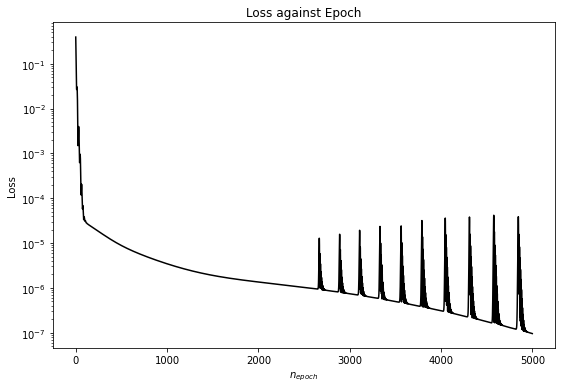

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.title("Loss against Epoch")
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Loss');

#6. Finding the cosine similarity

In [ ]:
cos_sim_ls = []
# Cosine values closer to -1 indicate greater similarity
# Cosine values closer to 0 indicates orthogonal
# and values closer to 1 indicate greater dissimilarity.
for grad_bc, grad_pde in zip(grad_bc_ls, grad_pde_ls):
  cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
  cos_sim_ls.append(cosine_loss(grad_bc, grad_pde).numpy())


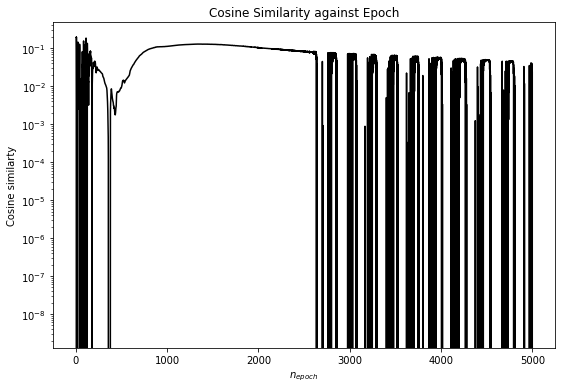

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.title("Cosine Similarity against Epoch")
ax = fig.add_subplot(111)
ax.semilogy(range(len(cos_sim_ls)), cos_sim_ls,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Cosine similarty');